<a href="https://colab.research.google.com/github/NLP-END3/Session11/blob/main/BERT_Tutorial_How_To_Build_a_Question_Answering_Bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT Tutorial- How To Build a Question Answering Bot

Article by Michel Kana: https://towardsdatascience.com/bert-nlp-how-to-build-a-question-answering-bot-98b1d1594d7b

Code credits to Michel Kana, and Prachur Bhargava, Lead Data Scientist @ Microsoft

In [1]:
# verify GPU availability
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
# install huggingface libraries
!pip install pytorch-pretrained-bert pytorch-nlp pytorch_transformers

In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig, BertModel
from pytorch_transformers import AdamW, BertForQuestionAnswering
from tqdm import tqdm, trange
import pandas as pd
import io
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: ignored

In [5]:
%%bash
wget -q 'https://raw.githubusercontent.com/NLP-END3/Session11/main/run_squad.py'
wget -q 'https://raw.githubusercontent.com/NLP-END3/Session11/main/utils_squad.py'
wget -q 'https://raw.githubusercontent.com/NLP-END3/Session11/main/utils_squad_evaluate.py'

In [6]:
!wget -q 'https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json'

In [10]:
from utils_squad import (read_squad_examples, convert_examples_to_features,
                         RawResult, write_predictions,
                         RawResultExtended, write_predictions_extended)
from utils_squad_evaluate import EVAL_OPTS, main as evaluate_on_squad, plot_pr_curve

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
input_file = 'train-v2.0.json'
examples = read_squad_examples(input_file=input_file,
                                is_training=True,
                                version_2_with_negative=True)

In [10]:
examples[:5]

[qas_id: 56be85543aeaaa14008c9063, question_text: When did Beyonce start becoming popular?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".], start_position: 39, end_position: 42,
 qas_id: 56be85543aeaaa14008c9065, question_text: What areas did Beyonce compete in when she was growing up?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈ

In [11]:
train_data = pd.DataFrame.from_records([vars(example) for example in examples])
train_data.head()

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
0,56be85543aeaaa14008c9063,When did Beyonce start becoming popular?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",in the late 1990s,39,42,False
1,56be85543aeaaa14008c9065,What areas did Beyonce compete in when she was...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",singing and dancing,28,30,False
2,56be85543aeaaa14008c9066,When did Beyonce leave Destiny's Child and bec...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",2003,82,82,False
3,56bf6b0f3aeaaa14008c9601,In what city and state did Beyonce grow up?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...","Houston, Texas",22,23,False
4,56bf6b0f3aeaaa14008c9602,In which decade did Beyonce become famous?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",late 1990s,41,42,False


In [12]:
sample = train_data.sample(frac=1).head(1)
context = sample.doc_tokens.values
train_data[train_data.doc_tokens.values==context]

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
1438,56cffcf3234ae51400d9c20d,In what suite did Schumann name a work for Cho...,"[Chopin's, qualities, as, a, pianist, and, com...",Carnaval,24,24,False
1439,56cffcf3234ae51400d9c20e,What piece of Chopin's work was dedicated to S...,"[Chopin's, qualities, as, a, pianist, and, com...",Ballade No. 2 in F major,30,35,False
1440,56cffcf3234ae51400d9c20f,How many of Chopin's Polish songs did Liszt tr...,"[Chopin's, qualities, as, a, pianist, and, com...",six,56,56,False
1441,56cffcf3234ae51400d9c210,With who did Chopin feel comfortable speaking ...,"[Chopin's, qualities, as, a, pianist, and, com...",Alkan,67,67,False
1442,56d3a74159d6e414001468a1,What was recognized about Chopin from his musi...,"[Chopin's, qualities, as, a, pianist, and, com...",qualities as a pianist and composer,1,6,False
1443,56d3a74159d6e414001468a2,What Schumann suite contained the name of a pi...,"[Chopin's, qualities, as, a, pianist, and, com...",Carnaval,24,24,False
1444,56d3a74159d6e414001468a3,What piece did Chopin dedicate to Schumann?,"[Chopin's, qualities, as, a, pianist, and, com...",Ballade No. 2 in F major,30,35,False
1445,56d3a74159d6e414001468a4,What other musician shows to have elements of ...,"[Chopin's, qualities, as, a, pianist, and, com...",Liszt,48,48,False


In [58]:
import random
def print_squad_sample(train_data, line_length=14, separator_length=120):
  sample = train_data.sample(frac=1).head(1)
  context = sample.doc_tokens.values
  print('='*separator_length)
  print('CONTEXT: ')
  print('='*separator_length)
  lines = [' '.join(context[0][idx:idx+line_length]) for idx in range(0, len(context[0]), line_length)]
  for l in lines:
      print(l)
  print('='*separator_length)
  questions = train_data[train_data.doc_tokens.values==context]
  print('QUESTION:', ' '*(3*separator_length//4), 'ANSWER:')
  for idx, row in questions.iterrows():
    question = row.question_text
    answer = row.orig_answer_text
    print(question, ' '*(3*separator_length//4-len(question)+9), (answer if answer else 'No anwser found'))

In [14]:
print_squad_sample(train_data)

CONTEXT: 
During the Middle Ages Aristotle's theory of tabula rasa was developed by Islamic philosophers
starting with Al Farabi, developing into an elaborate theory by Avicenna and demonstrated as
a thought experiment by Ibn Tufail. For Avicenna (Ibn Sina), for example, the tabula
rasa is a pure potentiality that is actualized through education, and knowledge is attained
through "empirical familiarity with objects in this world from which one abstracts universal concepts"
developed through a "syllogistic method of reasoning in which observations lead to propositional statements
which when compounded lead to further abstract concepts". The intellect itself develops from a
material intellect (al-'aql al-hayulani), which is a potentiality "that can acquire knowledge to the
active intellect (al-'aql al-fa'il), the state of the human intellect in conjunction with the
perfect source of knowledge". So the immaterial "active intellect", separate from any individual person,
is still essential 

In [15]:
train_data['paragraph_len'] = train_data['doc_tokens'].apply(len)
train_data['question_len'] = train_data['question_text'].apply(len)
train_data.sample(frac=1).head(5)

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible,paragraph_len,question_len
42740,570e10d20b85d914000d7c9c,What was Antarctica presumed to be by the anci...,"[Antarctica, has, no, indigenous, population, ...",balance,39,39,False,107,59
61466,572cbdd6750c471900ed4d22,What kinds of agreements do contract law cover?,"[Contract, law, covers, obligations, establish...",express or implied,7,9,False,79,47
98436,572aaea4111d821400f38caa,How did Republicans attack Kerry?,"[With, the, continuing, controversy, that, had...",by calling Kerry's war record into question,78,84,False,192,33
91900,5728ee8dff5b5019007da999,When did Leochares make The Apollo Belvedere?,"[Apollo, as, a, handsome, beardless, young, ma...",between 350 and 325 BCE,84,88,False,89,45
21712,56ea9f495a205f1900d6d393,What is the minimum amount of people that can ...,"[In, the, context, of, political, corruption,,...",two,27,27,False,169,69


In [16]:
max_seq_length = 256
print("Percentage of context's less than max_seq_length = %s%%" % (len([l for l in train_data['paragraph_len'] if l <= max_seq_length])/len(train_data) * 100))

Percentage of context's less than max_seq_length = 98.19289589392184%


In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [18]:
doc_stride = 128
max_seq_length = 256
max_query_length = 64
# batch size of 64 if RAM available.
batch_size = 16

In [19]:
cached_features_file = './cache_train'

In [20]:
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=True)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [21]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [22]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_start_positions = torch.tensor([f.start_position for f in features], dtype=torch.long)
all_end_positions = torch.tensor([f.end_position for f in features], dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_start_positions, all_end_positions,
                        all_cls_index, all_p_mask)

In [23]:
train_sampler = RandomSampler(dataset)
train_dataloader = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size, drop_last=True)

In [23]:
import glob
checkpoints = sorted(glob.glob('./checkpoint*-[0-9]*'))

In [5]:
def to_list(tensor):
    return tensor.detach().cpu().tolist()

In [24]:
if len(checkpoints) > 0:
  global_step = checkpoints[-1].split('-')[-1]
  ckpt_name = './checkpoint-{}'.format(global_step)
  print("Loading model from checkpoint %s" % ckpt_name)
  model = BertForQuestionAnswering.from_pretrained(ckpt_name)
  train_loss_set_ckpt = torch.load(ckpt_name + '/training_loss.pt')
  train_loss_set = to_list(train_loss_set_ckpt)
  tr_loss = train_loss_set[-1]
else:
  global_step = 0
  train_loss_set = []
  tr_loss = 0.0
  model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')

model.cuda()

Loading model from checkpoint ./checkpoint-3000


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [27]:
param_optimizer = list(model.named_parameters())
print(param_optimizer[-2])
print(param_optimizer[-1])

('qa_outputs.weight', Parameter containing:
tensor([[-0.0156, -0.0034,  0.0158,  ...,  0.0163, -0.0092, -0.0156],
        [-0.0320,  0.0021,  0.0154,  ..., -0.0312,  0.0108, -0.0091]],
       device='cuda:0', requires_grad=True))
('qa_outputs.bias', Parameter containing:
tensor([0., 0.], device='cuda:0', requires_grad=True))


In [28]:
learning_rate = 5e-5
adam_epsilon=1e-8
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

In [29]:
num_train_epochs = 1

print("***** Running training *****")
print("  Num examples = %d" % len(dataset))
print("  Num Epochs = %d" % num_train_epochs)
print("  Batch size = %d" % batch_size)
print("  Total optimization steps = %d" % (len(train_dataloader) // num_train_epochs))

model.zero_grad()
train_iterator = trange(num_train_epochs, desc="Epoch")
set_seed()

for _ in train_iterator:
    epoch_iterator = tqdm(train_dataloader, desc="Iteration")
    for step, batch in enumerate(epoch_iterator):
      if step < global_step + 1:
        continue

      model.train()
      batch = tuple(t.to(device) for t in batch)

      inputs = {'input_ids':       batch[0],
                'attention_mask':  batch[1], 
                'token_type_ids':  batch[2],  
                'start_positions': batch[3], 
                'end_positions':   batch[4]}

      outputs = model(**inputs)

      loss = outputs[0]
      train_loss_set.append(loss)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      tr_loss += loss.item()
      optimizer.step()
      model.zero_grad()
      global_step += 1
    
      if global_step % 1000 == 0:
        print("Train loss: {}".format(tr_loss/global_step))
        output_dir = './checkpoint-{}'.format(global_step)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        torch.save(torch.tensor(train_loss_set), os.path.join(output_dir, 'training_loss.pt'))
        print("Saving model checkpoint to %s" % output_dir)

***** Running training *****
  Num examples = 144262
  Num Epochs = 1
  Batch size = 16
  Total optimization steps = 9016


Iteration:   0%|          | 0/9016 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pytorch_transformers/optimization.py:166: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)

Iteration:  11%|█         | 1000/9016 [14:06<1:52:54,  1.18it/s]

Train loss: 1.7794509025812149



Iteration:  11%|█         | 1001/9016 [14:08<2:58:42,  1.34s/it]

Saving model checkpoint to ./checkpoint-1000



Iteration:  22%|██▏       | 2000/9016 [28:14<1:38:36,  1.19it/s]

Train loss: 1.55423823659122



Iteration:  22%|██▏       | 2001/9016 [28:17<2:40:15,  1.37s/it]

Saving model checkpoint to ./checkpoint-2000



Iteration:  33%|███▎      | 3000/9016 [42:22<1:24:44,  1.18it/s]

Train loss: 1.447610228707393



Iteration:  33%|███▎      | 3001/9016 [42:25<2:18:52,  1.39s/it]

Saving model checkpoint to ./checkpoint-3000



Epoch:   0%|          | 0/1 [52:58<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
output_dir = './checkpoint-final'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)

In [25]:
train_loss_set_ckpt = torch.load('./checkpoint-final/training_loss.pt')
train_loss_set = to_list(train_loss_set_ckpt)

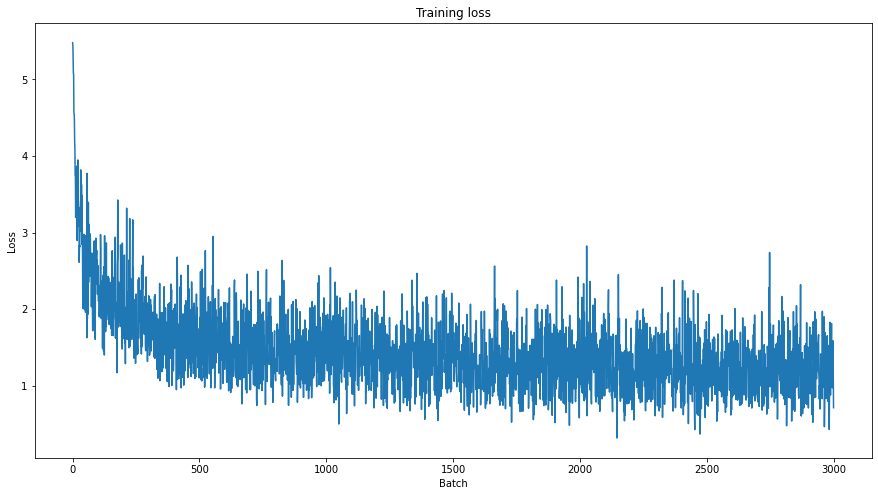

In [7]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [8]:
!wget -q 'https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json'

**Load test dataset**

In [15]:
input_file = './dev-v2.0.json'
val_examples = read_squad_examples(input_file=input_file,
                                is_training=False,
                                version_2_with_negative=True)
doc_stride = 128
max_seq_length = 256
max_query_length = 64
cached_features_file = './cache_validation'

# Cache features for faster loading
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=val_examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=False)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [16]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_example_index = torch.arange(all_input_ids.size(0), dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_example_index, all_cls_index, all_p_mask)

In [19]:
validation_sampler = SequentialSampler(dataset)
validation_dataloader = DataLoader(dataset, sampler=validation_sampler, batch_size=batch_size, drop_last=True)

**Evaluate test dataset**

In [20]:

def evaluate(model, tokenizer):
  print("***** Running evaluation *****")
  print("  Num examples = %d" % len(dataset))
  print("  Batch size = %d" % batch_size)
  all_results = []
  predict_file = './dev-v2.0.json'
  for batch in tqdm(validation_dataloader, desc="Evaluating", miniters=100, mininterval=5.0):
    model.eval()
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': batch[2]
                }
      example_indices = batch[3]
      outputs = model(**inputs)

    for i, example_index in enumerate(example_indices):
      eval_feature = features[example_index.item()]
      unique_id = int(eval_feature.unique_id)

      result = RawResult(unique_id    = unique_id,
                         start_logits = to_list(outputs[0][i]),
                         end_logits   = to_list(outputs[1][i]))
      all_results.append(result)

  # Compute predictions
  output_prediction_file = "./predictions.json"
  output_nbest_file = "./nbest_predictions.json"
  output_null_log_odds_file = "./null_odds.json"
  output_dir = "./predict_results"

  write_predictions(val_examples, features, all_results, 10,
                  30, True, output_prediction_file,
                  output_nbest_file, output_null_log_odds_file, False,
                  True, 0.0)

  # Evaluate with the official SQuAD script
  evaluate_options = EVAL_OPTS(data_file=predict_file,
                               pred_file=output_prediction_file,
                               na_prob_file=output_null_log_odds_file,
                               out_image_dir=None)
  results = evaluate_on_squad(evaluate_options)
  return results

In [26]:
results = evaluate(model, tokenizer)

***** Running evaluation *****
  Num examples = 13600
  Batch size = 16


Evaluating: 100%|██████████| 850/850 [03:56<00:00,  3.59it/s]


{
  "exact": 64.18765265728965,
  "f1": 67.7923735483939,
  "total": 11873,
  "HasAns_exact": 65.84008097165992,
  "HasAns_f1": 73.05986017882562,
  "HasAns_total": 5928,
  "NoAns_exact": 62.53994953742641,
  "NoAns_f1": 62.53994953742641,
  "NoAns_total": 5945,
  "best_exact": 67.4724164069738,
  "best_exact_thresh": -1.8365097045898438,
  "best_f1": 70.11927503789808,
  "best_f1_thresh": -1.615800380706787
}


In [27]:
import json
results_json = []
for k in enumerate(results.keys()):
  result_dict = {k[1] : results[k[1]]}
  results_json.append(result_dict)
print(results_json)
with open('results.json', 'w') as f:
  json.dump(results_json, f)

[{'exact': 64.18765265728965}, {'f1': 67.7923735483939}, {'total': 11873}, {'HasAns_exact': 65.84008097165992}, {'HasAns_f1': 73.05986017882562}, {'HasAns_total': 5928}, {'NoAns_exact': 62.53994953742641}, {'NoAns_f1': 62.53994953742641}, {'NoAns_total': 5945}, {'best_exact': 67.4724164069738}, {'best_exact_thresh': -1.8365097045898438}, {'best_f1': 70.11927503789808}, {'best_f1_thresh': -1.615800380706787}]


**Evaluate on test dataset**

In [97]:
import json
# Opening JSON file
with open('/content/predictions.json') as f:
 
    # returns JSON object as
    # a dictionary
    pred_data = json.load(f)

def print_squad_val_sample(train_data, pred_data, id, line_length=14, separator_length=120):
#   sample = train_data.sample(frac=1).head(1)
  sample = train_data[train_data.index==id]
  context = sample.doc_tokens.values
  print('='*separator_length)
  print('CONTEXT: ')
  print('='*separator_length)
  lines = [' '.join(context[0][idx:idx+line_length]) for idx in range(0, len(context[0]), line_length)]
  for l in lines:
      print(l)
  print('='*separator_length)
  questions = train_data[train_data.doc_tokens.values==context]
  print('QUESTION:', ' '*(3*separator_length//4), 'ANSWER:')
  for idx, row in questions.iterrows():
    qas_id = row.qas_id
    question = row.question_text
    answer = pred_data[qas_id]
    print(question, ' '*(3*separator_length//4-len(question)+9), (answer if answer else 'No anwser found'))
    # print(question, ' '*(3*separator_length//4-len(question)+9))

### Test Example 1

In [98]:
val_data = pd.DataFrame.from_records([vars(example) for example in val_examples])
print_squad_val_sample(val_data, pred_data,0)

CONTEXT: 
The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the
10th and 11th centuries gave their name to Normandy, a region in France. They
were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland
and Norway who, under their leader Rollo, agreed to swear fealty to King Charles
III of West Francia. Through generations of assimilation and mixing with the native Frankish
and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West
Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the
first half of the 10th century, and it continued to evolve over the succeeding
centuries.
QUESTION:                                                                                            ANSWER:
In what country is Normandy located?                                                                 France
When were the Normans in Norma

### Test Example 2

In [99]:
print_squad_val_sample(val_data, pred_data,10)

CONTEXT: 
The Norman dynasty had a major political, cultural and military impact on medieval Europe
and even the Near East. The Normans were famed for their martial spirit and
eventually for their Christian piety, becoming exponents of the Catholic orthodoxy into which they
assimilated. They adopted the Gallo-Romance language of the Frankish land they settled, their dialect
becoming known as Norman, Normaund or Norman French, an important literary language. The Duchy
of Normandy, which they formed by treaty with the French crown, was a great
fief of medieval France, and under Richard I of Normandy was forged into a
cohesive and formidable principality in feudal tenure. The Normans are noted both for their
culture, such as their unique Romanesque architecture and musical traditions, and for their significant
military accomplishments and innovations. Norman adventurers founded the Kingdom of Sicily under Roger II
after conquering southern Italy on the Saracens and Byzantines, and an expe

### Test Example 3



In [100]:
print_squad_val_sample(val_data, pred_data, 20)

CONTEXT: 
The English name "Normans" comes from the French words Normans/Normanz, plural of Normant, modern
French normand, which is itself borrowed from Old Low Franconian Nortmann "Northman" or directly
from Old Norse Norðmaðr, Latinized variously as Nortmannus, Normannus, or Nordmannus (recorded in Medieval
Latin, 9th century) to mean "Norseman, Viking".
QUESTION:                                                                                            ANSWER:
What is the original meaning of the word Norman?                                                     Norseman, Viking
When was the Latin version of the word Norman first recorded?                                        9th century
What name comes from the English words Normans/Normanz?                                              No anwser found
When was the French version of the word Norman first recorded?                                       Medieval Latin, 9th century


### Test Example 4

In [90]:
print_squad_val_sample(val_data, pred_data, 40)

CONTEXT: 
Soon after the Normans began to enter Italy, they entered the Byzantine Empire and
then Armenia, fighting against the Pechenegs, the Bulgars, and especially the Seljuk Turks. Norman
mercenaries were first encouraged to come to the south by the Lombards to act
against the Byzantines, but they soon fought in Byzantine service in Sicily. They were
prominent alongside Varangian and Lombard contingents in the Sicilian campaign of George Maniaces in
1038–40. There is debate whether the Normans in Greek service actually were from Norman
Italy, and it now seems likely only a few came from there. It is
also unknown how many of the "Franks", as the Byzantines called them, were Normans
and not other Frenchmen.
QUESTION:                                                                                            ANSWER:
Who was the Normans' main enemy in Italy, the Byzantine Empire and Armenia?                          Pechenegs, the Bulgars, and especially the Seljuk Turks
Who entered Ita

### Test Example 5

In [91]:
print_squad_val_sample(val_data, pred_data, 50)

CONTEXT: 
One of the first Norman mercenaries to serve as a Byzantine general was Hervé
in the 1050s. By then however, there were already Norman mercenaries serving as far
away as Trebizond and Georgia. They were based at Malatya and Edessa, under the
Byzantine duke of Antioch, Isaac Komnenos. In the 1060s, Robert Crispin led the Normans
of Edessa against the Turks. Roussel de Bailleul even tried to carve out an
independent state in Asia Minor with support from the local population, but he was
stopped by the Byzantine general Alexius Komnenos.
QUESTION:                                                                                            ANSWER:
When did Herve serve as a Byzantine general?                                                         1050s
When did Robert Crispin go up against the Turks?                                                     1060s
Who ruined Roussel de Bailleul's plans for an independent state?                                     Alexius Komnenos
Who was t